In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from PIL import Image
import glob
import os

# Walkthrough

This walkthrough gives a demo of using Topaz for particle picking with 30 micrographs from the EMPIAR-10025 dataset and a subset of the published particles simulating a small amount of manual labeling (50 particles per micrograph).

Topaz is assumed to be installed in a conda environment named "topaz" for purposes of running topaz commands within bash cells.

The tutorial dataset can be downloaded [here](http://bergerlab-downloads.csail.mit.edu/topaz/topaz-tutorial-data.tar.gz) and should be unpacked directly in this (the tutorial) directory.

```
wget http://bergerlab-downloads.csail.mit.edu/topaz/topaz-tutorial-data.tar.gz
tar -xzvf topaz-tutorial-data.tar.gz
```


# Preprocessing

In [3]:
%%bash
# we'll store the processed data in data/EMPIAR-10025/processed
mkdir -p data/EMPIAR-10025/processed
mkdir -p data/EMPIAR-10025/processed/micrographs

### Micrograph downsampling and normalization
We first downsample the full micrographs 16x and then normalize them with the per-micrograph scaled Gaussian mixture model. For convenience, this can be performed in one step with the 'preprocess' command, but the two steps can also be run separately with the 'downsample' and 'normalize' commands.

In [4]:
%%bash
source activate topaz
topaz preprocess -s16 -o data/EMPIAR-10025/processed/micrographs/ data/EMPIAR-10025/rawdata/micrographs/*.mrc

### Scale particle coordinates to match downsampled micrographs

In [5]:
%%bash
source activate topaz
# scale the particle coordinates to match the downsampling of the micrographs (factor is 1/16)
topaz scale_coordinates -s 0.0625 -o data/EMPIAR-10025/processed/particles.txt data/EMPIAR-10025/rawdata/particles.txt

In [6]:
%%bash
head data/EMPIAR-10025/processed/particles.txt

image_name	x_coord	y_coord
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	433	155
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	316	349
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	183	95
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	175	224
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	235	408
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	283	73
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	265	51
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	433	309
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	292	304


# Model training

### Preliminaries
1. create the image list file which matches micrograph names to file paths
2. holdout a test set of micrographs to evaluate the particle classifier

In [7]:
# first, we create a file mapping image_name to file path of that micrograph
image_list = []
for path in glob.glob('data/EMPIAR-10025/processed/micrographs/*.tiff'):
    name,_ = os.path.splitext(os.path.basename(path))
    image_list.append([name, path])
image_list = pd.DataFrame(image_list, columns=['image_name', 'path'])
image_list.to_csv('data/EMPIAR-10025/processed/image_list.txt', sep='\t', index=False)
image_list.head()

,image_name,path
0,14sep05c_c_00003gr_00015sq_00015hl_00002es_c,data/EMPIAR-10025/processed/micrographs/14sep0...
1,14sep05c_c_00003gr_00020sq_00011hl_00004es_c,data/EMPIAR-10025/processed/micrographs/14sep0...
2,14sep05c_c_00004gr_00031sq_00002hl_00002es_c,data/EMPIAR-10025/processed/micrographs/14sep0...
3,14sep05c_c_00003gr_00014sq_00011hl_00003es_c,data/EMPIAR-10025/processed/micrographs/14sep0...
4,14sep05c_c_00004gr_00032sq_00007hl_00003es_c,data/EMPIAR-10025/processed/micrographs/14sep0...


Next, we split the micrographs and their labeled particles into a training set and heldout test set. This is necessary to assess the expected performance of the model when predicting on non-training data. We can use the test set to cross-validate hyperparameter settings such as $\pi$, training radius, and model architecture if desired.

In [8]:
particles = pd.read_csv('data/EMPIAR-10025/processed/particles.txt', sep='\t')

random = np.random.RandomState(42)
order = random.permutation(len(image_list))
image_list_train = image_list.iloc[order][:20]
image_list_test = image_list.iloc[order][20:]

image_list_train.to_csv('data/EMPIAR-10025/processed/image_list_train.txt', sep='\t', index=False)
image_list_test.to_csv('data/EMPIAR-10025/processed/image_list_test.txt', sep='\t', index=False)

images_train = set(image_list_train['image_name'])
particles_train = []
particles_test = []
for name,group in particles.groupby('image_name'):
    if name in images_train:
        particles_train.append(group)
    else:
        particles_test.append(group)
particles_train = pd.concat(particles_train, ignore_index=True)
particles_test = pd.concat(particles_test, ignore_index=True)

particles_train.to_csv('data/EMPIAR-10025/processed/particles_train.txt', sep='\t', index=False)
particles_test.to_csv('data/EMPIAR-10025/processed/particles_test.txt', sep='\t', index=False)

len(image_list_train), len(particles_train), len(image_list_test), len(particles_test)

(20, 1000, 10, 500)

### Model fitting



In [9]:
%%bash
# store the saved models and, later, predicted particles in saved_models/EMPIAR-10025
mkdir -p saved_models
mkdir -p saved_models/EMPIAR-10025

When fitting the classifier, the most important parameters to set are __$\pi$ (--pi)__ and the __training radius (--radius)__. $\pi$ specifies the expected fraction of positive pixels. The radius parameter specifies how many pixels around a labeled particle coordinate should be treated as positive during training, because the training procedure considers all pixels within radius to be positive. Increasing this parameter can improve training by helping to smooth out noise in labeled particle centers and adding extra positive pixels. However, increasing this parameter too much can cause problems for particle extraction later by making it harder to identify particle centers from the dense pixel scores. We find that setting this parameter to 3 or 4 is generally best and it should always be less than the particle radius.

The model architecture can also be specified with the --model flag along with several architecture hyperparameters. Autoencoder weight hyperparameter can be set with --autoencoder={} but is set to zero (off) by default. Please refer to the README for more options.

In [10]:
%%bash
source activate topaz
topaz train --radius=3 --pi=0.035 --model=conv31 \
            --num-workers=8 \
            --train-images data/EMPIAR-10025/processed/image_list_train.txt \
            --train-targets data/EMPIAR-10025/processed/particles_train.txt \
            --test-images data/EMPIAR-10025/processed/image_list_test.txt \
            --test-targets data/EMPIAR-10025/processed/particles_test.txt \
            --save-prefix=saved_models/EMPIAR-10025/model \
            -o saved_models/EMPIAR-10025/model_training.txt

# Loading model: conv31
# Model parameters: units=32, dropout=0.0, bn=on
# Receptive field: 31
# Using device=0 with cuda=True
# source	split	p	total
# 0	train	0.0065386002886	4435200
# 0	test	0.0065386002886	2217600
# minibatch_size=256, epoch_size=5000, num_epochs=10
# Done!


In [11]:
training_results = pd.read_csv('saved_models/EMPIAR-10025/model_training.txt', sep='\t')
training_results.loc[training_results['split'] == 'test']

,epoch,iter,split,loss,ge_penalty,precision,tpr,fpr,auprc
5000,1,5001,test,0.038076,-,0.041105,0.117501,0.018041,0.05687858164310455
10001,2,10001,test,0.036532,-,0.055977,0.150705,0.016727,0.06671150773763657
15002,3,15001,test,0.038913,-,0.055435,0.178280,0.019993,0.06766029447317123
20003,4,20001,test,0.043085,-,0.058273,0.225943,0.024032,0.07344861328601837
25004,5,25001,test,0.042997,-,0.060911,0.239958,0.024349,0.07966781407594681
30005,6,30001,test,0.038230,-,0.063873,0.197712,0.019071,0.07562244683504105
35006,7,35001,test,0.039831,-,0.065820,0.217215,0.020290,0.07935907691717148
40007,8,40001,test,0.040252,-,0.067628,0.222908,0.020226,0.08070426434278488
45008,9,45001,test,0.040847,-,0.066317,0.228126,0.021139,0.07997418195009232
50009,10,50001,test,0.041713,-,0.067952,0.228387,0.020618,0.07827899605035782


#### Note about AUPR
Because the test set is _partially_ labeled (i.e. only some particles are labeled as positives), the AUPR is an underestimate of the true AUPR, because the precision of the model is underestimated due to the unlabeled particles being considered negatives.

This means the AUPR for a test set is internally consistent - a model which has higher AUPR on the test set is picking better, but it is not comparable across datasets with different completeness of labeling.

# Particle extraction

Extract particles using an extraction radius of 7 pixels (-r7). This particle has diameter ~15 pixels in the downsampled micrographs, so using a radius of 7 prevents predicting multiple particle centers for a single particle.

In [12]:
%%bash
source activate topaz
topaz extract -r7 -m saved_models/EMPIAR-10025/model_epoch10.sav \
              -o saved_models/EMPIAR-10025/predicted_particles_all.txt \
              data/EMPIAR-10025/processed/micrographs/*.tiff

In [13]:
predicted_particles = pd.read_csv('saved_models/EMPIAR-10025/predicted_particles_all.txt', sep='\t')
predicted_particles.head()

,image_name,x_coord,y_coord,score
0,14sep05c_c_00003gr_00014sq_00004hl_00004es_c,276,178,3.89635
1,14sep05c_c_00003gr_00014sq_00004hl_00004es_c,266,217,3.82087
2,14sep05c_c_00003gr_00014sq_00004hl_00004es_c,200,229,3.45421
3,14sep05c_c_00003gr_00014sq_00004hl_00004es_c,163,321,3.39931
4,14sep05c_c_00003gr_00014sq_00004hl_00004es_c,186,270,3.35271


### Visualization
Given the particle coordinates and corresponding predicted scores above, we can visualize particles on a few micrographs held out in the test set.

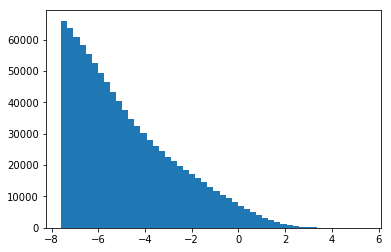

In [14]:
# plot the distribution of scores (predicted log-likelihood ratios)
_ = plt.hist(predicted_particles.score, bins=50, cumulative=-1)

In [15]:
np.sum(predicted_particles.score >= 0) # how many particles are predicted with score >= 0

6892

In [16]:
# visualize predictions on some test micrographs
test_micrographs = {}
for name in image_list_test['image_name']:
    path = 'data/EMPIAR-10025/processed/micrographs/' + name + '.tiff'
    im = np.array(Image.open(path), copy=False)
    test_micrographs[name] = im

14sep05c_c_00004gr_00032sq_00041hl_00005es_c


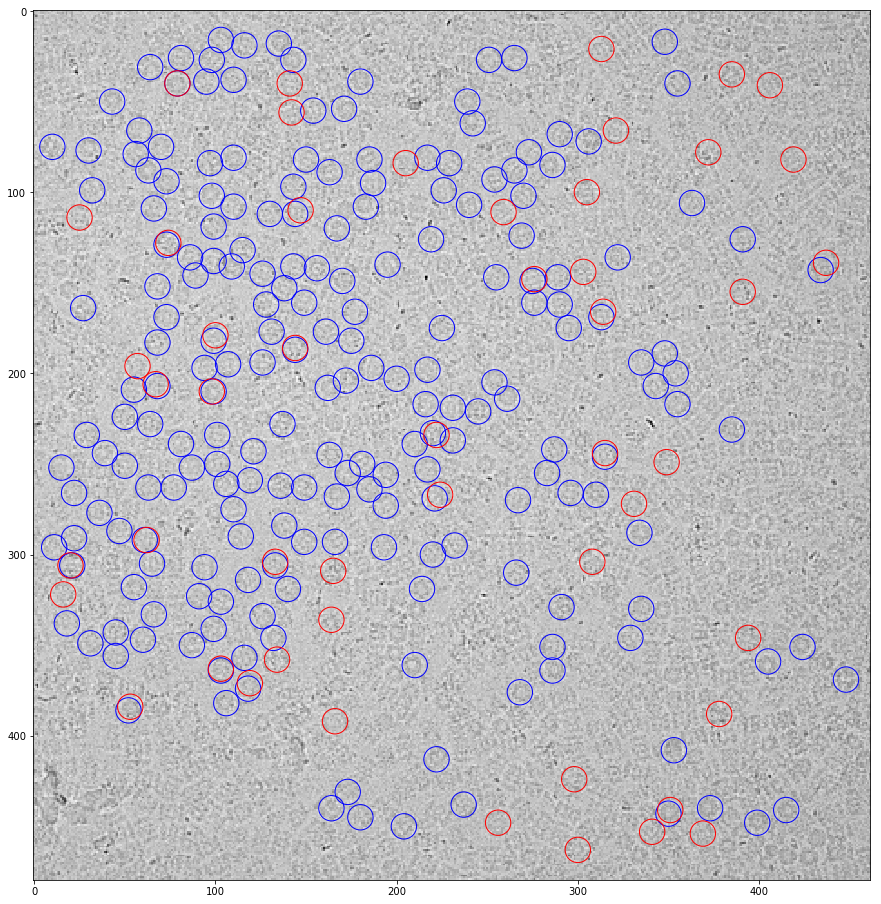

In [17]:
name = image_list_test['image_name'].iloc[0]
print(name)
im = test_micrographs[name]
particles = predicted_particles.loc[predicted_particles['image_name'] == name]

# visualize predicted particles with log-likelihood ratio >= 0 (p >= 0.5)
# this may be too stringent for this dataset
particles = particles.loc[particles['score'] >= 0]


_,ax = plt.subplots(figsize=(16,16))
ax.imshow(im, cmap='Greys_r')

radius = 7

# plot the predicted particles in blue
for x,y in zip(particles.x_coord, particles.y_coord):
    c = Circle((x,y),radius,fill=False,color='b')
    ax.add_patch(c)
    
# plot the (partial) ground truth particles in red
ground_truth = particles_test.loc[particles_test['image_name'] == name]
for x,y in zip(ground_truth.x_coord, ground_truth.y_coord):
    c = Circle((x,y),radius,fill=False,color='r')
    ax.add_patch(c)


14sep05c_c_00007gr_00013sq_00008hl_00003es_c


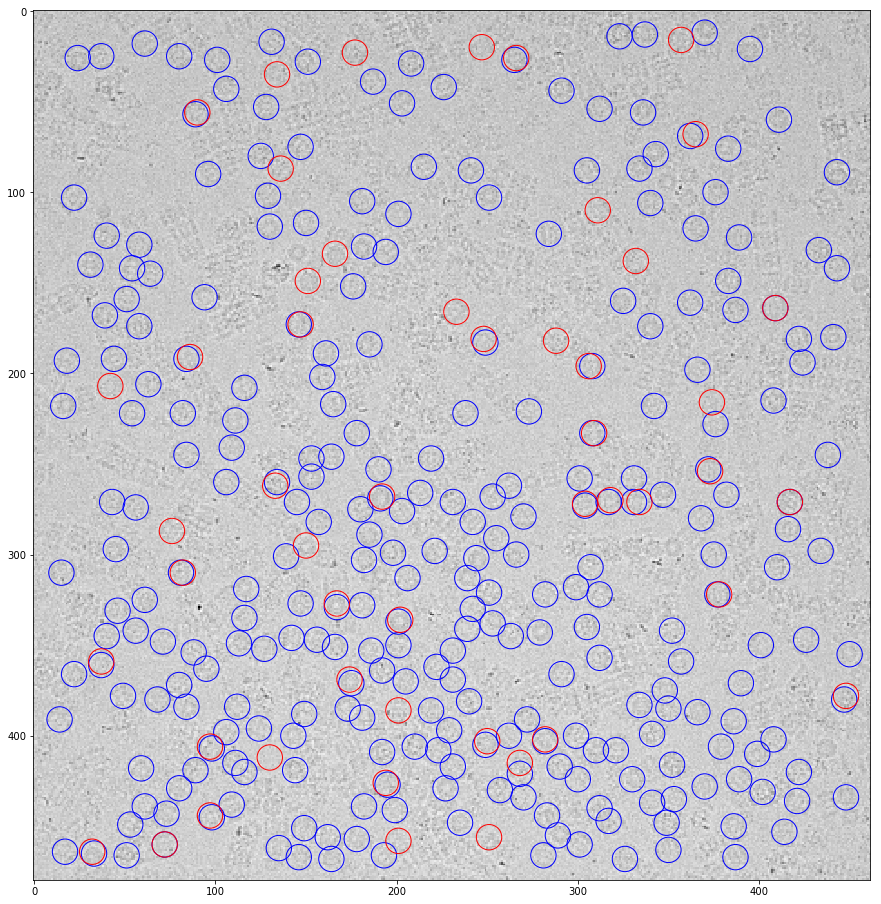

In [18]:
name = image_list_test['image_name'].iloc[1]
print(name)
im = test_micrographs[name]
particles = predicted_particles.loc[predicted_particles['image_name'] == name]
particles = particles.loc[particles['score'] >= 0]


_,ax = plt.subplots(figsize=(16,16))
ax.imshow(im, cmap='Greys_r')

radius = 7

# plot the predicted particles in blue
for x,y in zip(particles.x_coord, particles.y_coord):
    c = Circle((x,y),radius,fill=False,color='b')
    ax.add_patch(c)
    
# plot the (partial) ground truth particles in red
ground_truth = particles_test.loc[particles_test['image_name'] == name]
for x,y in zip(ground_truth.x_coord, ground_truth.y_coord):
    c = Circle((x,y),radius,fill=False,color='r')
    ax.add_patch(c)


14sep05c_c_00004gr_00032sq_00037hl_00002es_c


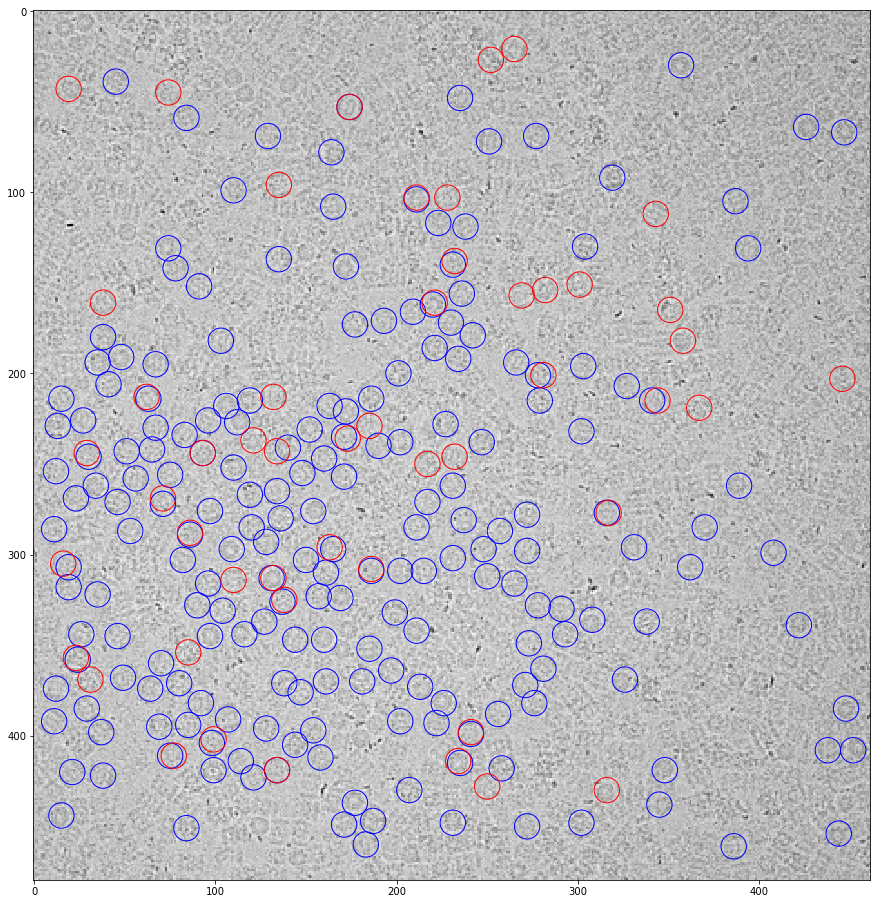

In [19]:
name = image_list_test['image_name'].iloc[2]
print(name)
im = test_micrographs[name]
particles = predicted_particles.loc[predicted_particles['image_name'] == name]
particles = particles.loc[particles['score'] >= 0]


_,ax = plt.subplots(figsize=(16,16))
ax.imshow(im, cmap='Greys_r')

radius = 7

# plot the predicted particles in blue
for x,y in zip(particles.x_coord, particles.y_coord):
    c = Circle((x,y),radius,fill=False,color='b')
    ax.add_patch(c)
    
# plot the (partial) ground truth particles in red
ground_truth = particles_test.loc[particles_test['image_name'] == name]
for x,y in zip(ground_truth.x_coord, ground_truth.y_coord):
    c = Circle((x,y),radius,fill=False,color='r')
    ax.add_patch(c)


In [20]:
## visualize the top 100 predicted particles
n = 10
s = 31
panel = np.zeros((n*s, n*s), dtype=np.float32)
predicted_particles_test = predicted_particles.loc[predicted_particles.image_name.isin(image_list_test.image_name)]
predicted_particles_test = predicted_particles_test.sort_values('score', ascending=False)
for i in range(n):
    for j in range(n):
        k = i*n + j
        name = predicted_particles_test.iloc[k].image_name
        x_coord = predicted_particles_test.iloc[k].x_coord
        y_coord = predicted_particles_test.iloc[k].y_coord
        im = test_micrographs[name]
        
        xs = x_coord - s//2
        xe = xs + s
        ys = y_coord - s//2
        ye = ys + s
        
        pxs = j*s
        pxe = j*s+s
        pys = i*s
        pye = i*s+s
        
        if xs < 0:
            pxs -= xs
            xs = 0
        if xe > im.shape[1]:
            pxe -= xe - im.shape[1]
            xe = im.shape[1]
        if ys < 0:
            pys -= ys
            ys = 0
        if ye > im.shape[0]:
            pye -= ye - im.shape[0]
            ye = im.shape[0]
        
        panel[pys:pye,pxs:pxe] = im[ys:ye,xs:xe]

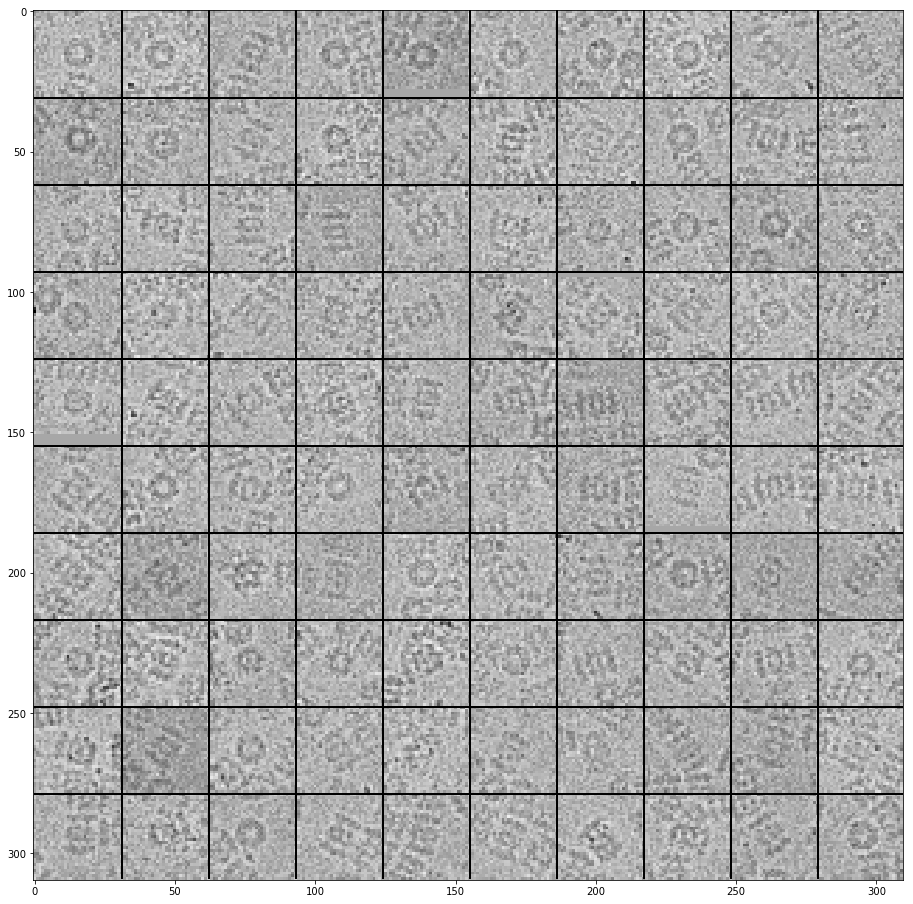

In [21]:
_,ax = plt.subplots(figsize=(16,16))
ax.imshow(panel, cmap='Greys_r')
for i in range(1,n):
    ax.plot([0,s*n-1],[i*s,i*s], 'k', linewidth=2)
    ax.plot([i*s,i*s],[0,s*n-1], 'k', linewidth=2)

As we can see, the model retrieves many more particles than are present in the incompletely labeled test set. The particles appear to be well centered and the top 100 particles show a nice mixture of side and top views.

## Generate MRC particle stack
Now that particles have been predicted, the particle coordinates can be scaled back up to the original (pre-downsampling) micrograph sizes. We provide utilities for converting the particle coordinates table to other file formats (.star, .box, .json) for compatability with downstream tools. We also provide a script for generating a .mrc file stack with corresponding .star file. 

In [22]:
%%bash
# first, upsample the predicted particles back to original micrograph resolution
source activate topaz
topaz scale_coordinates -s 16 -o saved_models/EMPIAR-10025/predicted_particles_all_upsampled.txt \
                        saved_models/EMPIAR-10025/predicted_particles_all.txt

In [23]:
%%bash
# here, we generate the particle stack using the predicted particles after upsamapling
# per-micrograph metadata (such as CTF parameters) can be optionally included in the 
# .star file generated with the particle stack

# --size specifies the dimensions of the particle crops
# --threshold specifies the score threshold above which to include particles in the stack
# --metadata is optional and in this case contains CTF parameters

# if output file is named "particles.mrc" then the .star file created will be "particles.star"
source activate topaz
topaz particle_stack --image-root=data/EMPIAR-10025/rawdata/micrographs/ \
                     --size=400 \
                     --threshold=0 \
                     --metadata=data/EMPIAR-10025/rawdata/ctf_params.star \
                     -o saved_models/EMPIAR-10025/predicted_particle_stack.mrc \
                     saved_models/EMPIAR-10025/predicted_particles_all_upsampled.txt

# Loaded 66067 particles
# Thresholding at 0.0
# Extracting 6892 particles
# 14sep05c_c_00003gr_00014sq_00004hl_00004es_c 244 particles
# 14sep05c_c_00003gr_00014sq_00005hl_00003es_c 237 particles
# 14sep05c_c_00003gr_00014sq_00007hl_00004es_c 206 particles
# 14sep05c_c_00003gr_00014sq_00011hl_00003es_c 259 particles
# 14sep05c_c_00003gr_00015sq_00015hl_00002es_c 292 particles
# 14sep05c_c_00003gr_00018sq_00008hl_00003es_c 266 particles
# 14sep05c_c_00003gr_00018sq_00010hl_00005es_c 246 particles
# 14sep05c_c_00003gr_00020sq_00011hl_00002es_c 271 particles
# 14sep05c_c_00003gr_00020sq_00011hl_00004es_c 268 particles
# 14sep05c_c_00004gr_00031sq_00002hl_00002es_c 283 particles
# 14sep05c_c_00004gr_00031sq_00005hl_00002es_c 268 particles
# 14sep05c_c_00004gr_00031sq_00010hl_00002es_c 315 particles
# 14sep05c_c_00004gr_00032sq_00007hl_00003es_c 199 particles
# 14sep05c_c_00004gr_00032sq_00010hl_00003es_c 145 particles
# 14sep05c_c_00004gr_00032sq_00029hl_00005es_c 99 particles
# 14sep05c_

Done! Now we have a particle stack generated by picking with Topaz.